<a href="https://colab.research.google.com/github/ToM4tto/Movie-Recommender-System/blob/main/movie_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CSD3185 Group 26 Machine Learning Project**: 
## MovieCompanion - A Movie Recommendation System

## Mounting Google Drive

In [1]:
#Load the Drive helper and mount
from google.colab import drive

#This will prompt for authorisation
drive.mount('/content/drive')

Mounted at /content/drive


## Loading Data

In [24]:
import pandas as pd 
import numpy as np 
df1 = pd.read_csv("/content/drive/MyDrive/tmdb_5000_movies.csv")
df2 = pd.read_csv("/content/drive/MyDrive/tmdb_5000_credits.csv")
df2.columns = ['id','title','cast','crew'] #df2 movie_id has to be renamed to id to merge w/ df1

# Merge the two DataFrames on the 'id' column
df1 = df1.merge(df2,on='id')

# Drop the duplicate column 'title_y'
df1 = df1.drop('title_y', axis=1)

# Rename the column 'title_x' to 'title'
df1 = df1.rename(columns={'title_x': 'title'})

#Peek our data
df1.head(3)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."


## Visualising Data

In [82]:
import matplotlib.pyplot as plt

#enable graph render inline on Jupyter notebooks
%matplotlib inline 

#Make smaller dataframe with lesser cols
ratings = df1[["title", "vote_average", "vote_count"]]

# Sort the DataFrame by highest vote_score given the highest vote_count
ratings = ratings.sort_values(['vote_count', 'vote_average'], ascending=[False, False])

#Peek at our data
ratings.head(5)

,title,vote_average,vote_count
96,Inception,8.1,13752
65,The Dark Knight,8.2,12002
0,Avatar,7.2,11800
16,The Avengers,7.4,11776
788,Deadpool,7.4,10995


Distribution of Vote_Count (frequency vs vote_count)


<AxesSubplot:>

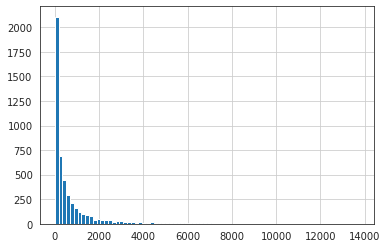

In [78]:
#Print Distribution of vote_count
print("Distribution of Vote_Count (frequency vs vote_count)")
ratings['vote_count'].hist(bins=80)

Distribution of Average Vote (frequency vs vote_average)


<AxesSubplot:>

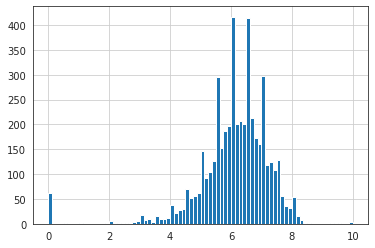

In [77]:
#Print Distribution of Average Votes
print("Distribution of Average Vote (frequency vs vote_average)")
ratings['vote_average'].hist(bins=80)